In [2]:
import os
import time as t
import re
import numpy as np
import math
from os import listdir
from os.path import isfile, join

from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as patches
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.gridspec as gridspec

from scipy.ndimage import imread
from scipy import ndimage
from scipy.ndimage.filters import gaussian_filter

from PIL import Image

from utils import *

In [153]:
path_input = u'e:\\Data\\burst\\'
path_output = u'e:\\Data\\burst\\'

raws = read_tiff(path_input + 'raws_16_45_00.tif', 100)
flats= read_tiff(path_input + 'flats_16_45_38.tif', 100)

In [154]:
# remove frames, startng form 1 as a first index value
index_remove_raw = np.array([2,9,10,17,18,25,32,33,40,41,48,49,56,64,71,72,79,
                             80,87,88,95,102,103,110,111,114,115]) - 1 
rest_frames = np.arange(116, 128)
remove_indexes = np.concatenate((index_remove_raw, rest_frames))
raws = np.delete(raws, remove_indexes, axis=0)

print(len(raws))

C:\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  


79


## Perform high-pass filtering for both flats and raw images

In [155]:
sigma = 2.0

flats_high_pass = []
for f in flats:
    flats_high_pass.append( (f + 0.001) / (gaussian_filter(f, sigma=sigma)+0.001))
  
mean_flat = np.mean(flats_high_pass, axis=0)

raws_high_pass = []
for r in raws:
    raws_high_pass.append( (r + 0.001) / (gaussian_filter(r, sigma=sigma)+0.001))



Number of flats 89


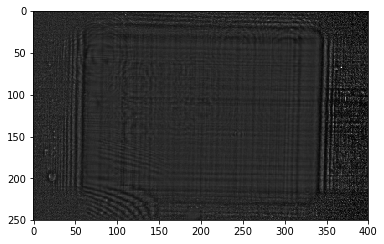

In [156]:
plt.imshow(mean_flat, cmap='gray')
print('Number of flats', len(flats))

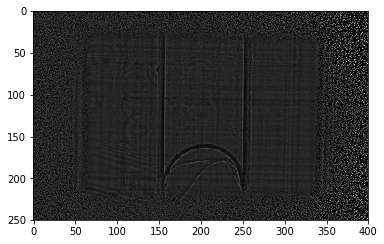

In [157]:
i = 0

im = raws_high_pass[0]
flat = flats_high_pass[0]

plt.imshow(im, cmap='gray')

## Correction with avarage flat field

In [158]:


results = raws_high_pass - mean_flat
save_seq_as_multitiff_stack(results, path_output + 'seq_corrected.tif')

## TEST: Adaptive correction

400 250


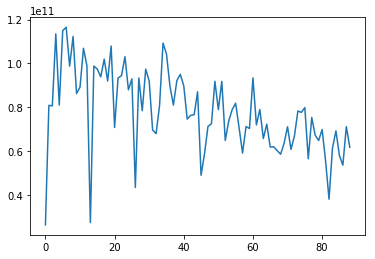

6


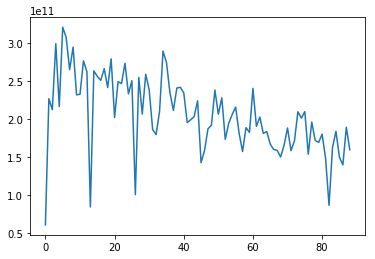

5


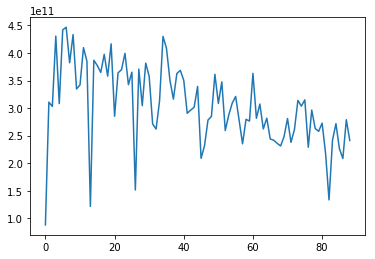

6


In [150]:

w = raws[0].shape[1]
h = raws[0].shape[0]

print(w,h)

pw = 10
ph = 10

diff_threshold = 0.1

grid = np.zeros_like(mean_flat)

results = []

masks = []

for n in range(0,3):
    
    im = raws_high_pass[n]

    flat_diff_stat = []


    #for k in tqdm(range(len(flats))):
    for k in range(len(flats)):
        
        mask = np.zeros_like(mean_flat)

        flat = flats[k]

        sum_diff = 0

        for i in range(0, int(h / ph)):
            for j in range(0 , int(w / pw)):
                patch = im[i*ph:i*ph+ph, j*pw:j*pw+pw]
                bg_patch = mean_flat[i*ph:i*ph+ph, j*pw:j*pw+pw]     
                flat_patch = flat[i*ph:i*ph+ph, j*pw:j*pw+pw]

                diff = np.abs(patch - bg_patch)

                #if np.mean(diff) < diff_threshold:
                if True:
                    #grid[i*ph:i*ph+ph, j*pw:j*pw+pw] = 1  
                    mask[i*ph:i*ph+ph, j*pw:j*pw+pw] = 1 
                    
                    # Correlation
                    sum_diff += np.sum(patch  * flat_patch)
                    #sum_diff += np.sum(np.log(patch + 0.001) * np.log(flat_patch+0.001))
                    #sum_diff += np.mean(np.abs(patch - flat_patch))

        flat_diff_stat.append(sum_diff)
    
    masks.append(mask)
        
    # Get the best flat
    best_index = np.argmax(flat_diff_stat)           
    best_flat = flats_high_pass[best_index] 
    
    #plt.plot(flat_diff_stat)
    #plt.show()
    
    print(best_index)
    
    res = im - best_flat
    
    results.append(res)
    
save_seq_as_multitiff_stack(results, path_output + 'seq_corrected.tif')
save_seq_as_multitiff_stack(masks, path_output + 'seq_masks.tif')
save_seq_as_multitiff_stack(flats_high_pass, path_output + 'seq_flats_high_pass.tif')

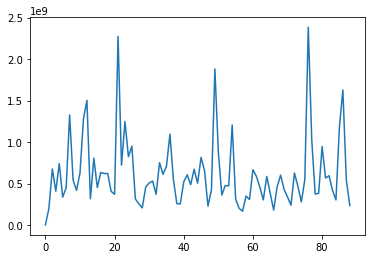

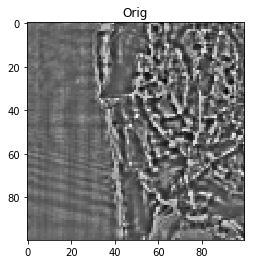

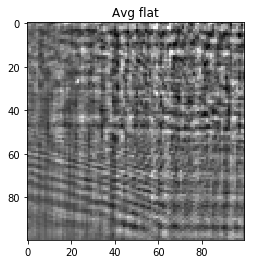

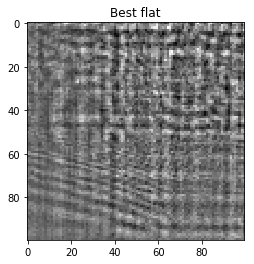

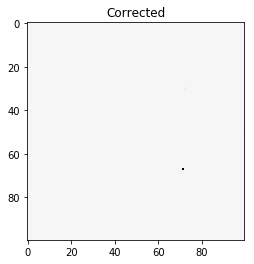

In [149]:

plt.plot(flat_diff_stat)
plt.show()

plt.imshow(im[100:200, 100:200], cmap='gray')
plt.title('Orig')
plt.show()

plt.imshow(mean_flat[100:200, 100:200], cmap='gray')
plt.title('Avg flat')
plt.show()

plt.imshow(best_flat[100:200, 100:200], cmap='gray')
plt.title('Best flat')
plt.show()

res = im / best_flat

plt.imshow(res[100:200, 100:200], cmap='gray')
plt.title('Corrected')
plt.show()

im_corr = Image.fromarray(mean_flat)
im_corr.save(path_output + 'mean_flat.tif')